In [2]:
import pandas as pd
import numpy as np
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from random import randrange
from wordcloud import WordCloud

In [3]:
# Baixar recursos do NLTK (se necessário)
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [59]:
stopwords_especificas = [
    "vc", "voce", "vcs", "tá", "ta", "to", "tô", "pq", "q", "né", "eh", "ai", "aí", "c", "d", "já",
    "pro", "pra", "pras", "nois", "tbm", "tb", "que", "oq", "ctz", "td", "toda", "todo", "todos", "ja",
    "ate", "até", "dps", "qdo", "cm", "rt", "from", "rs", "aff", "dae", "dai", "so", "só", "la", "lá","cade",
    "xq", "x", "tam", "vlw", "obg", "ne", "n", "ñ", "nn", "nao", "sim", "s", "ss", "pfv", "pf", "plz",
    "cadê", "kd", "aki", "aqui", "ali", "dali", "naquele", "naquela", "naquilo", "aonde", "dela", "dele",
    "deles", "delas", "mt", "mto", "mtos", "mta", "mtas", "oh", "ah", "ui", "ops", "wtf", "lol", "ftw",
    "oxe", "argh", "eita", "ih", "ui", "epa", "oba", "ufa", "aham", "hmm", "hm", "hi", "hein", "puf",
    "tipo", "tipo assim", "mano", "cara", "vei", "gente", "galera", "fia", "fi", "tamo", "vamo", "bora",
    "sao", "vai", "vem", "aonde", "donde", "onde", "aqui", "dali", "ma", "meu", "minha", "nosso", "nossa"
]

stopwords_tradicionais = set(stop_words)

stopwords_especificas = set(stopwords_especificas)

STOPWORDS_COMPLETA = stopwords_tradicionais.union(stopwords_especificas)

In [5]:
def remover_palavras_exatas(texto: str, palavras: list[str]) -> str:
    """
    Remove palavras exatas do texto usando regex, sem remover substrings.

    Args:
        texto (str): Texto de entrada.
        palavras (list[str]): Lista de palavras a remover (exatamente).

    Returns:
        str: Texto com as palavras removidas.
    """
    for palavra in palavras:
        # Remove a palavra com delimitador de palavra (\b) e insensível a maiúsculas
        padrao = rf'\b{re.escape(palavra)}\b'
        texto = re.sub(padrao, '', texto, flags=re.IGNORECASE)

    # Limpa múltiplos espaços e espaços antes de pontuação
    texto = re.sub(r'\s{2,}', ' ', texto)
    texto = re.sub(r'\s+([,.!?;:])', r'\1', texto)

    return texto.strip()

In [60]:
# 2. Pré-processamento (corrigido) [99%]
import unicodedata
import string
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

def clean_text(text):
    '''
    Perform stop-words removal and lemmatization
    '''

    text = str(text)

    text = text.lower()

    text_normalize = unicodedata.normalize("NFKD", text)
    text = ''.join(
        char for char in text_normalize
        if not unicodedata.combining(char)
    )

    text = text.encode('ascii', 'ignore').decode('utf-8')

    words = text.split()
    for word in words:
        if re.search('http', word) or re.search('https', word):
            text = text.replace(word, '')

        if re.search('@', word) or re.search('#', word):
            text = text.replace(word, '')

        if re.search('kk', word) or re.search("hah", word) or re.search('aha', word):
            text = text.replace(word, '')

    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    words = [word for word in text.split() if (word not in STOPWORDS_COMPLETA)]
    words = [WordNetLemmatizer().lemmatize(word) for word in words]

    return " ".join(words)

In [61]:
datasets = [
    'Datasets/OLID - BR/2019-05-28_portuguese_hate_speech_binary_classification.csv',
    'Datasets/OffComBR-3/OffComBR3.csv',
    'Datasets/Offcom2/OffComBR2.csv',
    'Datasets/ToLD/ToLD-BR_binario.csv',
    'Datasets/hateBR/HateBR.csv'
]

text=['text','mensagem','comentario','text','comentario']
label = ['hatespeech_comb','label','label','Discurso_de_odio','label_final']
for dataset,label in zip(datasets,label) :
  df = pd.read_csv(dataset)
  print("Coleção de dados : {}\nShape : {}\nInstâncias : {}\n\n".format(
      dataset.split('/')[-1],
      df.shape,
      df[label].value_counts()
      ))


Coleção de dados : 2019-05-28_portuguese_hate_speech_binary_classification.csv
Shape : (5670, 8)
Instâncias : hatespeech_comb
0    3882
1    1788
Name: count, dtype: int64


Coleção de dados : OffComBR3.csv
Shape : (1033, 2)
Instâncias : label
no     831
yes    202
Name: count, dtype: int64


Coleção de dados : OffComBR2.csv
Shape : (1250, 2)
Instâncias : label
no     831
yes    419
Name: count, dtype: int64


Coleção de dados : ToLD-BR_binario.csv
Shape : (21000, 15)
Instâncias : Discurso_de_odio
0    11742
1     9258
Name: count, dtype: int64


Coleção de dados : HateBR.csv
Shape : (7000, 8)
Instâncias : label_final
1    3500
0    3500
Name: count, dtype: int64




In [62]:
import random
for text_,dataset in zip(text,datasets):
  df = pd.read_csv(dataset)
  texto = df[text_]
  texto = texto[random.randrange(len(df))]
  limpo = clean_text(texto)
  print("Texto Original : {}\nTexto Limpo : {}\n\n".format(texto,limpo))


Texto Original : @agnaldoregojr 
2) O fato de o cidadão de bem passar a portar uma arma não o transformará em bandido.
Crime é questão de índole!
Texto Limpo : 2 fato cidadao bem passar portar arma transformara bandido crime questao indole


Texto Original : 'VAMOS MASSA ATLETICANA LOTAR O MINEIRAO E APOIA O PRATTO'
Texto Limpo : vamos massa atleticana lotar mineirao apoia pratto


Texto Original : 'Junta todos os pontas do Fla que nao da um Cueva'
Texto Limpo : junta pontas fla cueva


Texto Original : rt @user torpedo russo na red burro pra ontem https://t.co/v3a4kixheu
Texto Limpo : torpedo russo red burro ontem


Texto Original : Que homens lindos 😍😍 maravilhosos, inteligentes, queridos!
Texto Limpo : homens lindos maravilhosos inteligentes queridos




In [72]:
datasets = [
    'Datasets/OLID - BR/2019-05-28_portuguese_hate_speech_binary_classification.csv',
    'Datasets/OffComBR-3/OffComBR3.csv',
    'Datasets/Offcom2/OffComBR2.csv',
    'Datasets/ToLD/ToLD-BR_binario.csv',
    'Datasets/hateBR/HateBR.csv'
]

text=['text','mensagem','comentario','text','comentario']
label = ['hatespeech_comb','label','label','Discurso_de_odio','label_final']
INDEX=3

In [73]:
# 2.1. Data Frame Treatment & Training and Matching Separation
import pandas as pd
import re
from sklearn.model_selection import train_test_split

def load_and_prepare_data(filepath, text_colum, label_colum):
    """Carrega e prepara os dados"""
    # Carregar dados
    df_TextLabel = pd.read_csv(filepath)

    # Limpar textos
    df_TextLabel['cleaned_text'] = df_TextLabel[text_colum].apply(clean_text)

    # Filtrar colunas necessárias
    df_TextLabel = df_TextLabel[['cleaned_text', label_colum]]
    df_TextLabel.columns = ['text', 'label']

    # Remover linhas vazias
    df_TextLabel = df_TextLabel.dropna()
    df_TextLabel = df_TextLabel[df_TextLabel['text'] != '']

    return df_TextLabel

def split_data(df_TextLabel):
    """Divide os dados em treino e teste"""
    text_var = df_TextLabel['text']
    label_var = df_TextLabel['label']
    return train_test_split(text_var, label_var, test_size=0.2, random_state=42)

file_path = datasets[INDEX]
text_colum = text[INDEX]
label_colum = label[INDEX]
df = load_and_prepare_data(file_path, text_colum, label_colum)
text_train, text_test, label_train, label_test = split_data(df)

In [57]:
import pandas
len(pandas.read_csv(dataset)[text_])

7000

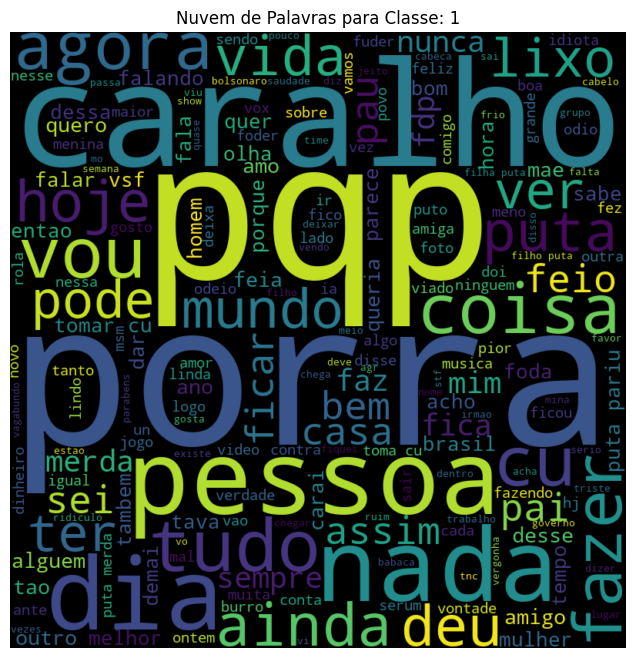

In [81]:
# 2.2.1. Data Exploration & Visualization (Word Cloud)
import pandas as pd
import re
from sklearn.model_selection import train_test_split

classes = df['label'].unique()
random_class = classes[randrange(len(classes))]

class_text = ' '.join(df[df['label'] == random_class]['text'])
class_text = ' '.join(df['text'])

# Gerar a nuvem de palavras
wordcloud = WordCloud(width=800, height=800,
                         background_color='black',
                         stopwords="portuguese",
                         collocations=True).generate(class_text)

# Plotar
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'Nuvem de Palavras para Classe: {random_class}')
plt.show()

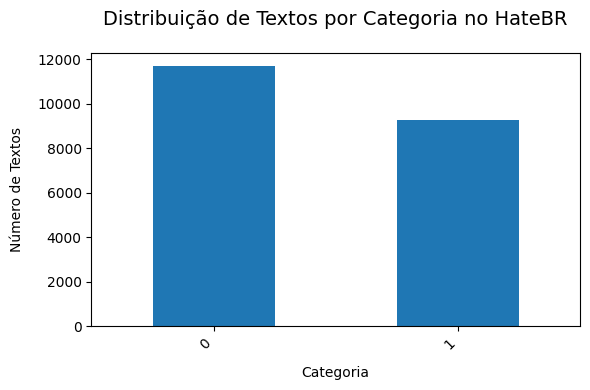

In [112]:
# 2.2.2. Visualisation (Visualizing word count balance in bar chart) [99%]

category_column = "label"

# Criando o gráfico
plt.figure(figsize=(6, 4))

# Contando os textos por categoria e plotando
df.groupby(category_column).size().sort_values(ascending=False).plot.bar(color='#1f77b4')

# Adicionando título e labels
plt.title("Distribuição de Textos por Categoria no HateBR", pad=20, fontsize=14)
plt.xlabel("Categoria", labelpad=10)
plt.ylabel("Número de Textos", labelpad=10)
plt.xticks(rotation=45, ha='right')

# Ajustando layout para não cortar rótulos
plt.tight_layout()

# Mostrando o gráfico
plt.show()

In [83]:
# 3. TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=5, ngram_range=(1, 2))

In [84]:
from sklearn.metrics import f1_score
# 4.1. Classification (Model Trainer)
# Fit the TF-IDF vectorizer on the training data and transform
X_train_vectorized = tfidf_vectorizer.fit_transform(text_train)
X_test_vectorized = tfidf_vectorizer.transform(text_test)

In [93]:
# Multinomial Naive Bayes
mnb = MultinomialNB().fit(X_train_vectorized, label_train)
y_pred_mnb = mnb.predict(X_test_vectorized)
print(f"Naive Bayes\nAccuracy: {accuracy_score(label_test, y_pred_mnb):.2f}\nF1-Score : {f1_score(label_test, y_pred_mnb):.2f}")

Naive Bayes
Accuracy: 0.72
F1-Score : 0.65


In [98]:
# Random Forest
rf = RandomForestClassifier().fit(X_train_vectorized, label_train)
y_pred_rf = rf.predict(X_test_vectorized)
print(f"Random Forest\nAccuracy: {accuracy_score(label_test, y_pred_rf):.2f}\nF1-Score : {f1_score(label_test, y_pred_rf):.2f}")

Random Forest
Accuracy: 0.75
F1-Score : 0.72


In [92]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression().fit(X_train_vectorized, label_train)
y_pred_lg = lg.predict(X_test_vectorized)
print(f"Logistic Regression\nAccuracy: {accuracy_score(label_test, y_pred_lg):.2f}\nF1-Score : {f1_score(label_test, y_pred_lg):.2f}")

Logistic Regression
Accuracy: 0.74
F1-Score : 0.68


In [96]:
# K-Neighbors Classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier().fit(X_train_vectorized, label_train)
y_pred_knn = knn.predict(X_test_vectorized)
print(f"K-Neighbors Classifier\nAccuracy: {accuracy_score(label_test, y_pred_knn):.2f}\nF1-Score : {f1_score(label_test, y_pred_knn):.2f}")

K-Neighbors Classifier
Accuracy: 0.62
F1-Score : 0.41


In [97]:
from sklearn.svm import LinearSVC
svc = LinearSVC().fit(X_train_vectorized, label_train)
y_pred_svc = svc.predict(X_test_vectorized)
print(f"Support Vector Classifier\nAccuracy: {accuracy_score(label_test, y_pred_svc):.2f}\nF1-Score : {f1_score(label_test, y_pred_svc):.2f}")

Support Vector Classifier
Accuracy: 0.72
F1-Score : 0.67


In [ ]:
# 5. Analysis (Matriz)
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_metrics = confusion_matrix(label_test, y_pred_mnb)

class_names = np.unique(np.concatenate((label_test, y_pred_mnb)))
sns.heatmap(confusion_metrics, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [99]:
# 4.2 Classification (Exemple Prediction) [0% ainda não testei nem estudei]
teste = tfidf_vectorizer.transform(["Você é um lindo"])
rf.predict(teste)

array([0])

In [121]:
# 4.2 Classification (Exemple Prediction) [0% ainda não testei nem estudei]
teste = tfidf_vectorizer.transform(["Você é um lixo"])
rf.predict(teste)

array([0])